---
title: Extreme Learning Machine in 3 Lines of Code
date: 2023-02-11
---

# Introduction (optional read)

The extreme learning machine (ELM) model is a machine learning (ML) technique that can be applied to both regression and classification problems. ELM is a feed-forward neural network with one hidden layer. The most important difference between a regular feed-forward neural network with one hidden layer and ELM is that **ELM does not use backpropagation** to learn its weights and biases. Instead, all weights and biases that map input vectors to the single hidden layer are assigned random values, and the weights that map the hidden layer to the output (a predicted target in the case of regression) are learned via least squared, not unlike ordinary least squares (OLS) linear regression. In fact, we will see shortly that the equation for ELM and OLS have the exact same form. It should be clear that the main advantage of ELM is reduced training time relative to training a neural network with the same architecture using backpropagation. One disadvantage of ELM is the questionable practice of assigning random values to the weights and biases that map input vectors to the single hidden layer. It is unclear how this affects the generalizability of ELM.

ELM was popularized by a 2006 paper titled "Extreme learning machine: Theory and applications" by Huang, Zhu and Siew. ELM has been a controversial topic, and while I won't go into details here, you can start with [this great article](https://towardsdatascience.com/some-call-it-genius-others-call-it-stupid-the-most-controversial-neural-network-ever-created-2224ed22795a) if you want to dig into the drama.

# ELM algorithm in math

Given a training set {{< math >}}$D=\left\{\left(\mathbf{x}_i, y_i\right) \mid \mathbf{x}_i \in \mathbf{R}^p, y_i \in \mathbf{R}, i=1, \ldots, N\right\}${{< /math >}}, activation function {{< math >}}$g(x)${{< /math >}}, and hidden node number {{< math >}}$L${{< /math >}},

- **Step 1**: Randomly assign input weight {{< math >}}$\mathbf{w}_i${{< /math >}} and bias {{< math >}}$b_i, i=1, \ldots, L${{< /math >}}.
- **Step 2**: Calculate the hidden layer output matrix {{< math >}}$\mathbf{H}${{< /math >}}.
- **Step 3**: Calculate the output weight {{< math >}}$\beta=\mathbf{H}^{\dagger} \mathbf{y}${{< /math >}}, where {{< math >}}$\mathbf{y}=\left[y_1, \ldots, y_N\right]^{\mathrm{T}}${{< /math >}} and {{< math >}}$\dagger${{< /math >}} indicates the Moore-Penrose Pseudo-inverse.

The hidden layer output matrix looks as follows:

{{< math >}}
$$
\mathbf{H}=\left[\begin{array}{ccc}g\left(\mathbf{w}_1 \cdot \mathbf{x}_1+b_1\right) & \cdots & g\left(\mathbf{w}_{L} \cdot \mathbf{x}_1+b_{L}\right) \\ \vdots & \cdots & \vdots \\ g\left(\mathbf{w}_1 \cdot \mathbf{x}_N+b_1\right) & \cdots & g\left(\mathbf{w}_{L} \cdot \mathbf{x}_N+b_{L}\right)\end{array}\right]_{N \times L}.
$$
{{< /math >}}

Notice that each row in {{< math >}}$\mathbf{H}${{< /math >}} corresponds to the hidden layer output for sample {{< math >}}$\mathbf{x}_i${{< /math >}}.

If we collect the hidden layer weights into a matrix {{< math >}}$\mathbf{W}=\left[\mathbf{w}_1, \cdots, \mathbf{w}_L\right]_{p \times L}${{< /math >}}, hidden layer biases into a vector {{< math >}}$\mathbf{b} = [b_1, \cdots, b_L]^\mathrm{T}${{< /math >}}, and input features {{< math >}}$\{\mathbf{x}_i\}${{< /math >}} into an {{< math >}}$N \times p${{< /math >}} matrix {{< math >}}$\mathbf{X} = [\mathbf{x}_1, \cdots, \mathbf{x}_N]^\mathrm{T}${{< /math >}}, we can compute {{< math >}}$\mathbf{H}${{< /math >}} in one go by

{{< math >}}
$$
\mathbf{H} = g\left(\mathbf{X}\mathbf{W}+\mathbf{b}\right)
$$
{{< /math >}}

where {{< math >}}$g(\cdot)${{< /math >}} is applied element-wise.

# ELM algorithm in code

In [2]:
import numpy as np

# g(x)
def sigmoid_activation(x):
    return 1/(1+np.exp(-x))

# Create a dummy dataset
p = 5                        # Number of input features
N = 10000                    # Numver of observations
X = np.random.random((N, p))
Y = np.random.random(N)

L = 10 # Number of hidden nodes

# ELM code; 3 lines
W, b = np.random.random((p, L)), np.random.random(L) # Step 1: Weight matrix, bias vector
H = sigmoid_activation((X @ W) + b)                  # Step 2: Hidden layer output matrix
beta_hat = np.linalg.pinv(H) @ Y                     # Step 3: Output weights

Here is what the output weight vector looks like:

In [3]:
beta_hat

array([-0.49835507, -0.68508437, -0.12280456,  0.37581779, -0.04470077,
        3.09404425, -1.1261844 , -0.89855811, -1.14341015,  1.46157009])

# How do we make predictions?

At inference time, the same weight matrix and bias vector that was randomly generated at training time must be used. This is a key implementation detail. Otherwise, prediction is straight-forward:

- **Step 1**: Take new input features {{< math >}}$\mathbf{X}_{new}${{< /math >}} and compute {{< math >}}$\mathbf{H}_{new}${{< /math >}} using the same {{< math >}}$\mathbf{W}$ and $\mathbf{b}${{< /math >}} generated at training time.
- **Step 2**: Compute predictions {{< math >}}$\mathbf{\hat{y}}=\mathbf{H}_{new}\mathbf{\hat{\beta}}${{< /math >}}, where {{< math >}}$\mathbf{\hat{\beta}}${{< /math >}} is the output weight vector learned at training time.

# Application: California housing data set (optional read)

If you're well versed in the Python library Scikit-Learn, here I implement a custom `sklearn` regression estimator and use it to perform a grid search over various hidden layer sizes. I use the California housing data set, which is provided in `sklearn`. The [California housing data set](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) is a classic toy data set.

In [6]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True)

Let's analyze the effect of `L` (number of nodes in the hidden layer) on prediction performance. We will define prediction performance as the coefficient of determination (R squared) evaluated using 10 fold cross validation.

First, we will define a custom `sklearn` regression estimator class that implements ELM.

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class NaiveELM(BaseEstimator, RegressorMixin):

    def __init__(self, L = 10):
        self.L = L

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Inputs
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (real numbers in regression).
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=True)

        p = X.shape[1]
        self.W = np.random.random((p, self.L))
        self.b = np.random.random(self.L)
        H = sigmoid_activation((X @ self.W) + self.b)
        self.beta_hat = np.linalg.pinv(H) @ y
        self.is_fitted_ = True

        return self

    def predict(self, X):
        """
        Inputs
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
        """
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        
        # At inference time, we use the same W and b generated during training
        H = sigmoid_activation((X @ self.W) + self.b)
        y_hat = H @ self.beta_hat

        return y_hat

Let's test run our custom `NaiveELM` estimator using 10 hidden nodes, and evaluate model performance for each fold:

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('elm', NaiveELM())])
cross_val_score(pipeline, X, y, scoring='r2', cv=10)

array([0.4774286 , 0.62912263, 0.18474884, 0.29791226, 0.30588241,
       0.46966579, 0.05484954, 0.43242109, 0.22834019, 0.48071248])

We are ready to do a grid search over different values of `L` (number of hidden nodes). Let's try values of `L` between 1 and 200 (inclusive).

In [9]:
from sklearn.model_selection import validation_curve

param_range = np.array(range(1, 200 + 1))

train_scores, test_scores = validation_curve(
    pipeline,
    X,
    y,
    param_name="elm__L", # IMPORTANT to use double underscore to specify hyperparameter
    param_range=param_range,
    cv = 10,
    scoring="r2",
    n_jobs=6,
)

We visualize the result of our grid search below. The following code was almost entirely copy-pasted from [Scikit-Learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py).

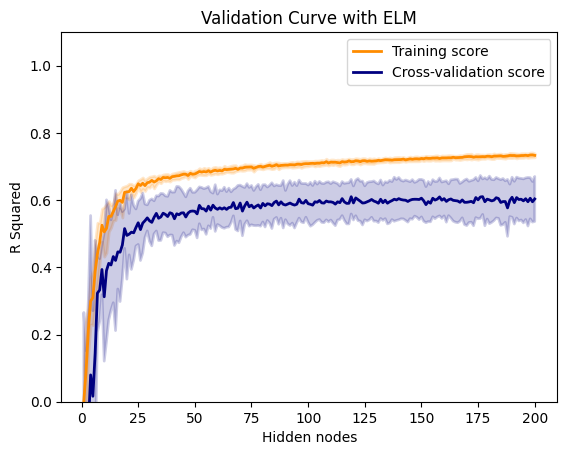

In [11]:
import matplotlib.pyplot as plt

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with ELM")
plt.xlabel("Hidden nodes")
plt.ylabel("R Squared")
plt.ylim(0.0, 1.1)
lw = 2

plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)

plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)

plt.legend(loc="best")
plt.show()

# Relation to OLS (optional read)

As you may have already figured, ELM and OLS share the same equation. The equation for ELM is

{{< math >}}
$$
\mathbf{y} = \mathbf{H} \mathbf{\beta}
$$
{{< /math >}}

while the equation for the OLS linear model is

{{< math >}}
$$
\mathbf{y} = \mathbf{X} \mathbf{\beta^*}
$$
{{< /math >}}

(I used {{< math >}}$\mathbf{\beta^*}${{< /math >}} to distinguish the OLS coefficients from the ELM output weight vector {{< math >}}$\beta${{< /math >}}.) For simplicity I did not include an error term in the above equations. Interestingly, if we include an error term in the ELM model equation like so

{{< math >}}
$$
\mathbf{y} = \mathbf{H} \mathbf{\beta} + \mathbf{\epsilon}
$$
{{< /math >}}

we can adopt a Bayesian linear regression approach to ELM, known as Bayesian Extreme Learning Machine (BELM), which allows us to obtain probability densities for predictions. For further details, see [Soria-Olivas, 2011](https://www.researchgate.net/publication/49776685_BELM_Bayesian_extreme_learning_machine).

# Final thoughts

I think the extreme learning machine model is a great way to introduce neural networks to students who are already familiar with linear regression. ELM has a simple architecture, shares the same equation as linear regression, is easy to implement, and fast in both training and predicting. ELM should certainly be given more love in educational institutions.

Thanks for reading!